# 1. Generate images set out of original lunar DEM tile (60 m/pix)
download file and initialize workspace: 

In [1]:
# !wget -P ../data/ http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2
from PIL import Image
import time
Image.MAX_IMAGE_PIXELS = 353894500
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import input_data_gen as igen
import utils.processing as proc
import h5py
import utils.maplot

data_path='../data/'

In [2]:
# Read source image.
img = Image.open(data_path + "/sldem2015_512_00n_30n_000_045.jp2")
print(img.format, img.size, img.mode)
# [Min long, max long, min lat, max lat] dimensions of source image.
source_cdim = [0., 45., 0., 30.]

JPEG2000 (23040, 15360) I;16


153.5656967163086


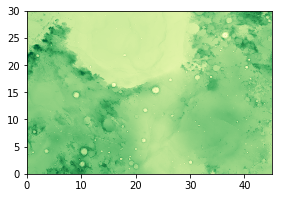

In [3]:
start_time = time.time()
fig = plt.figure(figsize=[6, 3])
dem_map = plt.imshow(img, extent=source_cdim, aspect="equal", cmap="YlGn")
elapsed_time = time.time() - start_time
print(elapsed_time)

Crop img to img_cr:

In [4]:
box = (0,1800,3600,3600)
ex_box = source_cdim*(np.array(box)/(img.size+img.size))[[0,2,1,3]]
img_cr=img.crop(box)
print(img_cr.format, img_cr.size, img_cr.mode)

None (3600, 1800) I;16


Conversion from 16-bit to 8-bit:

1.248722791671753


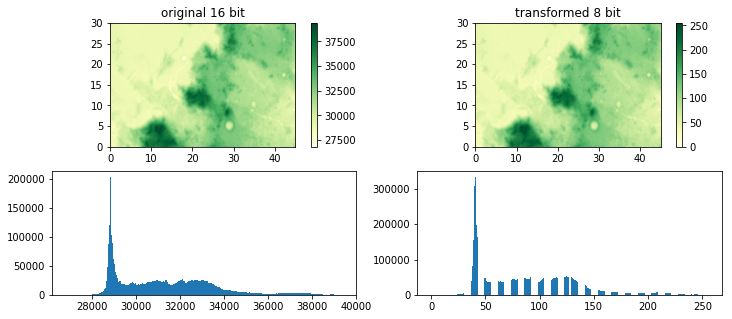

In [9]:
start_time = time.time()

img16=np.asarray(img_cr)
img16vec=np.concatenate(img16)

fig=plt.figure(figsize=(12,5))
#plot original image 16 bit+histogram:
plt.subplot(2,2,1)
plt.title('original 16 bit')
plt.imshow(img16, extent=source_cdim, aspect="equal", cmap="YlGn")
plt.colorbar()

plt.subplot(2,2,3)
plt.hist(img16vec, 256*2);


#transformation: 
min_val = np.min(img16vec)
dif = (np.max(img16vec)-min_val)
img8 = np.uint8((img16-min_val)/dif*256)

#plot transformed 8 bit+hist:
plt.subplot(2,2,2)
plt.title('transformed 8 bit')
plt.imshow(img8, extent=source_cdim, aspect="equal", cmap="YlGn")
plt.colorbar()

plt.subplot(2,2,4)
plt.hist(np.concatenate(img8), 256*2);

elapsed_time = time.time() - start_time
print(elapsed_time)

Define conversion function:

In [10]:
from PIL import Image
import numpy as np
def convert16to8bit(img):
    """Transform PIL image of 16-bit to 8-bit"""
    img16=np.asarray(img)
    img16vec=np.concatenate(img16)

    #transformation: 
    min_val = np.min(img16vec)
    dif = (np.max(img16vec)-min_val)
    img8 = np.uint8((img16-min_val)/dif*256)

    return Image.fromarray(img8)

In [13]:
print(img.format, img.size, img.mode)
start_time = time.time()
con_img=convert16to8bit(img)
elapsed_time = time.time() - start_time
print(elapsed_time)
print(con_img.format, con_img.size, con_img.mode)

6.068177938461304


In [20]:
# Read the Robbins dataset (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="catalogues/RobbinsLunarCraters.csv")
# craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc="catalogues/LROCCraters.csv",
#                                   filehead="catalogues/HeadCraters.csv")
craters = igen.ResampleCraters(craters, source_cdim, con_img.size[1]) #crop relevant part
craters.tail()

,Long,Lat,Diameter (km)
94386,4.25390,29.9959,0.820359
94387,37.03420,29.9962,0.640441
94388,20.19260,29.9970,0.768377
94389,29.56810,29.9982,0.991164
94390,2.29662,29.9998,1.154190


In [21]:
fn = '../data/test_SLDEM4'
sub_cdim = [0., 20., 0., 30.]

# If True, script prints out the image it's currently working on.
verbose = True

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(con_img, source_cdim, sub_cdim)

craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])

start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256, 2000], seed=1337, verbos)

elapsed_time = time.time() - start_time
if verbose:
    print("Time elapsed: {0:.1f} min".format(elapsed_time / 60.))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 0.0 min


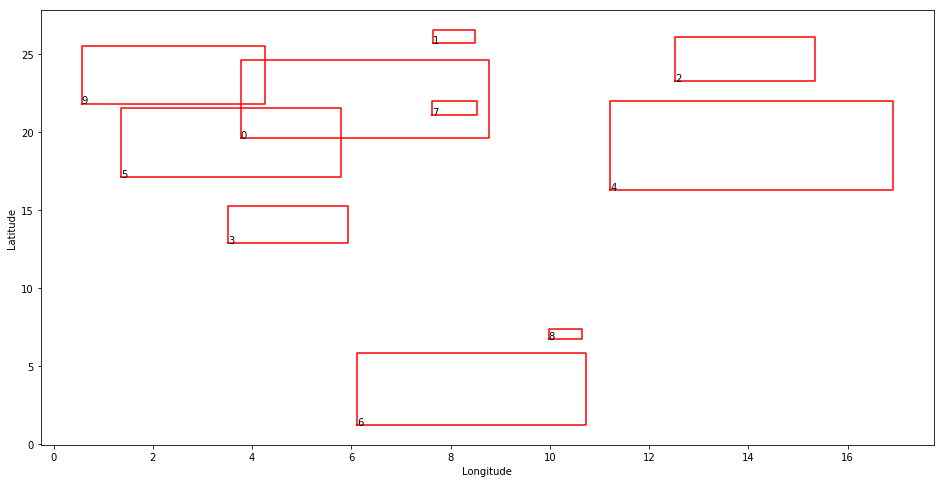

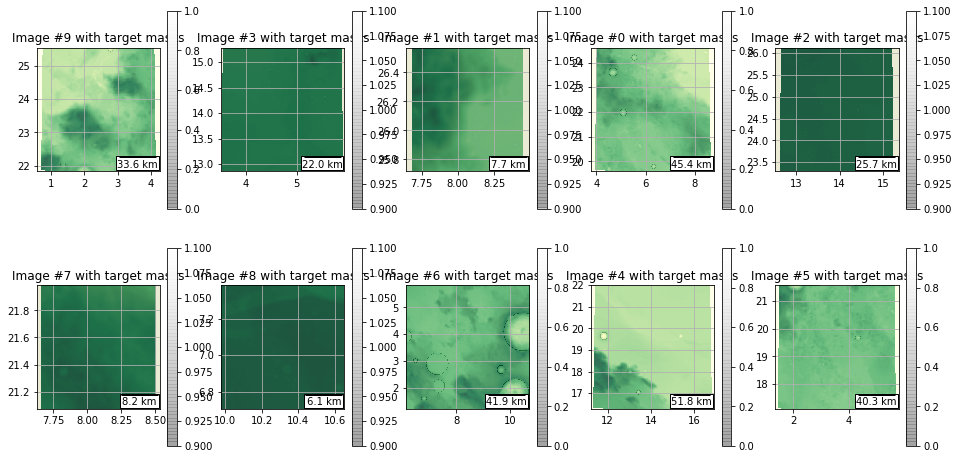

In [18]:
fn = '../data/test_SLDEM3'
sub_cdim = [0., 20., 0., 30.]

gen_imgs = h5py.File(fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}

# See 5 images of the set we produced: 
show_subset = np.random.choice(range(len(gen_imgs['cll_xy'])),size=10, replace=False)
fig = plt.figure(figsize=[16, 8])
# dem_map = plt.imshow(img, extent=sub_cdim, aspect="equal", cmap="YlGn")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='k')

# plt.colorbar()
    
fig2 = plt.figure(figsize=[16, 8])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  utils.maplot.plot_map_w_scalebar2(ax,gen_imgs,im_num)

# 2. Test model on frames from new DEM

In [25]:
import keras
keras.__version__

Using TensorFlow backend.


'1.2.2'

In [76]:
from keras.models import load_model
import sys
deepmoon_path='../DeepCrater'
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Use the commented out line for Keras 2.0+
# model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(data_path + '/model_keras1.2.2.h5')

In [77]:
fn = '../data/test_SLDEM4'
gen_imgs = h5py.File(fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


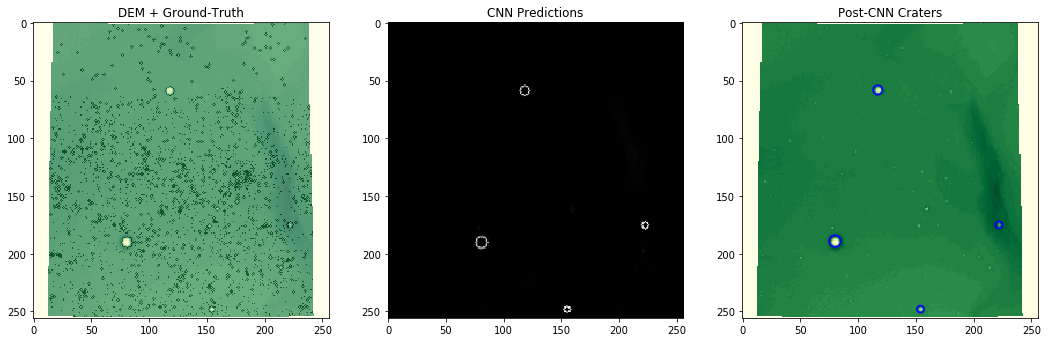

In [121]:
# Use the CNN to make a prediction.  We use [iwant:iwant + 1] to keep input as a 4D tensor.
# Input data MUST BE PREPROCESSED (see proc.preprocess, above) before being passed into model.predict
iwant = show_subset[2]
pred = model.predict(sd_input_images[iwant:iwant + 1])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=1.)
fig = plt.figure(figsize=[18, 6])
[ax1, ax2, ax3] = fig.subplots(1, 3)
ax1.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap='YlGn')
ax1.imshow(1-sd_target_masks[iwant].squeeze(), origin='upper', cmap='Greys_r', alpha=0.3)
ax2.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax3.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap="YlGn")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.9)
    ax3.add_artist(circle)
ax1.set_title('DEM + Ground-Truth')
ax2.set_title('CNN Predictions')
ax3.set_title('Post-CNN Craters')
plt.show()

In [122]:
import pandas as pd
df=pd.DataFrame(data=extracted_rings, columns=['x','y','r'])
print(df)
df.pivot_table(index='r', aggfunc='count')

     x    y  r
0  222  175  3
1  154  248  3
2  117   58  4
3   80  189  5


,x,y
r,,
3,2,2
4,1,1
5,1,1


In [22]:
img=gen_imgs['input_images'][4]
# print(type(img), img.size, img.shape)
np.unique(img.flatten())

array([  0,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178], dtype=uint8)